## 1. Libraries and settings

In [1]:
import numpy as np
import random
import pandas as pd 
from pylab import mpl, plt
plt.style.use('seaborn-v0_8-darkgrid')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

import math, time
import itertools
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import torch
import torch.nn as nn
from torch.autograd import Variable

import vectorbtpro as vbt

from datetime import date

import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler

import warnings
warnings.simplefilter("ignore", UserWarning)

vbt.settings.set_theme('dark')
vbt.settings['plotting']['layout']['width'] = 800
vbt.settings['plotting']['layout']['height'] = 400

sequence_length = 80  # Example: 20 timesteps per sequence
# Update these dimensions based on your dataset
input_dim = 11  # Number of features

output_dim = 3  # Number of classes

num_epochs = 80
learning_rate=0.03
step_size=20
gamma=0.8

print_epochs = 1

In [2]:
df = pd.read_csv('2ySOLdata1h.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df.set_index('timestamp', inplace=True)

df['signal'] = df['signal'].replace({'SignalNone': 1, 'SignalLong': 2, 'SignalShort': 0})
df.fillna(method='pad');


/var/folders/x1/twdts0414gn1_4rw0fsqsphm0000gn/T/ipykernel_65554/3057766720.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['signal'] = df['signal'].replace({'SignalNone': 1, 'SignalLong': 2, 'SignalShort': 0})
/var/folders/x1/twdts0414gn1_4rw0fsqsphm0000gn/T/ipykernel_65554/3057766720.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='pad');


In [3]:
data = vbt.Data.from_data(df)

open_price = data.get('Open')
high_price = data.get('High')
low_price = data.get('Low')
close_price = data.get('Close')

adx = vbt.ADX.run(high_price, low_price, close_price, window=14)
atr = vbt.ATR.run(high_price, low_price, close_price, window=14)
bbands = vbt.BBANDS.run(close_price, window=14)
rsi = vbt.RSI.run(close_price)
sma = vbt.MA.run(close_price, window=20)
strend = vbt.SUPERTREND.run(high_price, low_price, close_price, period=7, multiplier=3)

data.data['symbol']['ADX'] = adx.adx
data.data['symbol']['ATR'] = atr.atr
data.data['symbol']['BBAND'] = bbands.bandwidth
data.data['symbol']['RSI'] = rsi.rsi
data.data['symbol']['SMA'] = sma.ma
data.data['symbol']['STREND'] = strend.trend
data.data['symbol'] = data.data['symbol'].dropna()
predictor_list = ['Open', 'High', 'Low', 'Close', 'Volume', 'ADX', 'ATR', 'BBAND', 'RSI', 'SMA', 'STREND']

X = data.data['symbol'][predictor_list]

y = data.data['symbol']['signal']

In [4]:

test_size = int(0.3*(len(X)))
X_train = X[:-test_size]
X_test = X[-test_size:]

y_train = y[:-test_size]
y_test = y[-test_size:]



In [5]:
scl = RobustScaler()

X_train_scaled=scl.fit_transform(X_train)
X_train= X_train.assign(Open=X_train_scaled[:, 0])
X_train= X_train.assign(High=X_train_scaled[:, 1])
X_train= X_train.assign(Low=X_train_scaled[:, 2])
X_train= X_train.assign(Close=X_train_scaled[:, 3])
X_train= X_train.assign(Volume=X_train_scaled[:, 4])
X_train= X_train.assign(ADX=X_train_scaled[:, 5])
X_train= X_train.assign(ATR=X_train_scaled[:, 6])
X_train= X_train.assign(BBAND=X_train_scaled[:, 7])
X_train= X_train.assign(RSI=X_train_scaled[:, 8])
X_train= X_train.assign(SMA=X_train_scaled[:, 9])
X_train= X_train.assign(STREND=X_train_scaled[:, 10])


X_test_scaled=scl.transform(X_test)

X_test= X_test.assign(Open=X_test_scaled[:, 0])
X_test= X_test.assign(High=X_test_scaled[:, 1])
X_test= X_test.assign(Low=X_test_scaled[:, 2])
X_test= X_test.assign(Close=X_test_scaled[:, 3])
X_test= X_test.assign(Volume=X_test_scaled[:, 4])
X_test= X_test.assign(ADX=X_test_scaled[:, 5])
X_test= X_test.assign(ATR=X_test_scaled[:, 6])
X_test= X_test.assign(BBAND=X_test_scaled[:, 7])
X_test= X_test.assign(RSI=X_test_scaled[:, 8])
X_test= X_test.assign(SMA=X_test_scaled[:, 9])
X_test= X_test.assign(STREND=X_test_scaled[:, 10])

In [6]:
timestep = 80
X_train_list = []
y_train_list = []

# Adjust the range to stop at the last point where a full timestep can be created
for i in range(timestep, len(X_train) - timestep + 1):  # Adjust the loop to stop earlier
    X_train_list.append(np.array(X_train.iloc[i-timestep:i]))
    # Only append the next value instead of a range of values
    y_train_list.append(y_train.iloc[i])  # Assuming you want the next value as the target

X_test_list = []
y_test_list = []

for i in range(timestep, len(X_test) - timestep + 1):  # Adjust the loop to stop earlier
    X_test_list.append(np.array(X_test.iloc[i-timestep:i]))
    # Only append the next value instead of a range of values
    y_test_list.append(y_test.iloc[i])  # Assuming you want the next value as the target

In [7]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Convert lists to tensors
X_train_tensor = torch.tensor(X_train_list, dtype=torch.float)
y_train_tensor = torch.tensor(y_train_list, dtype=torch.float)
X_test_tensor = torch.tensor(X_test_list, dtype=torch.float)
y_test_tensor = torch.tensor(y_test_list, dtype=torch.float)


In [8]:
# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
batch_size = 64  # You can adjust this size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [9]:
# x_train = np.array(X_train_list)
# x_test = np.array(X_test_list)  
# y_train = np.array(y_train_list)
# y_test = np.array(y_test_list)

# # make training and test sets in torch
# x_train = torch.from_numpy(x_train).type(torch.Tensor)
# x_test = torch.from_numpy(x_test).type(torch.Tensor)
# y_train = torch.from_numpy(y_train).long()
# y_test = torch.from_numpy(y_test).long()


from sklearn.utils.class_weight import compute_class_weight

# Assuming y_train is your target labels tensor for the training data
# and it's already in the form of a 1D tensor of class indices (0 to C-1)

# Convert y_train to a numpy array if it's a tensor
if isinstance(y_train, torch.Tensor):
    y_train_np = y_train.cpu().numpy()
else:
    y_train_np = y_train  # Assuming y_train is already a numpy array

# Calculate class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_np), y=y_train_np)

# Convert class weights to a tensor
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

# Move class weights to the same device as your model and data
class_weights_tensor = class_weights_tensor.to('cpu')  # device could be 'cpu' or 'cuda'

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TransformerClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, num_heads, dropout_rate=0.1, max_seq_length=80):
        super(TransformerClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # If your input_dim != hidden_dim, use a linear layer to match dimensions
        self.linear = nn.Linear(input_dim, hidden_dim) if input_dim != hidden_dim else None
        
        # Positional Encoding
        self.positional_encoding = PositionalEncoding(hidden_dim, dropout_rate)

        
        # Transformer Encoder Layer
        encoder_layers = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads, dropout=dropout_rate)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # Match input dimension to hidden dimension if necessary
        if self.linear:
            x = self.linear(x)
            
        x = self.positional_encoding(x)
        
        # Transformer Encoder
        transformer_out = self.transformer_encoder(x)
        
        # Take the output of the last time step
        out = self.fc(transformer_out[:, -1, :])
        
        return out

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        max_len = 5000
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # Adjusting positional encoding to use broadcasting
        # This avoids manual repetition and relies on PyTorch's broadcasting
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)






# Initialize model parameters

hidden_dim = 512
num_layers = 6

num_heads = 8
dropout_rate = 0.1
max_seq_length = 80 # maximum sequence length

# Correct instantiation without max_seq_length
model = TransformerClassifier(input_dim=input_dim, hidden_dim=hidden_dim, num_layers=num_layers, output_dim=output_dim, num_heads=num_heads, dropout_rate=dropout_rate)


# Use CrossEntropyLoss for multi-class classification
# Initialize the loss function with class weights
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)

# Optimizer
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Assuming `optimizer` is your optimizer (e.g., Adam)
scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size=step_size, gamma=gamma)


In [11]:
# Assuming loss_fn is defined, optimiser and scheduler are configured
hist = np.zeros(num_epochs)

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    for X_batch, y_batch in train_loader:
        # Forward pass
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch.long())  # Adjust loss function as necessary

        # Backward pass and optimize
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

    # Logging
    if epoch % print_epochs == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 1.0986173152923584
Epoch 1, Loss: 1.203559160232544
Epoch 2, Loss: 1.2303590774536133
Epoch 3, Loss: 1.0621049404144287
Epoch 4, Loss: 1.1155400276184082
Epoch 5, Loss: 1.194867491722107
Epoch 6, Loss: 1.6122699975967407
Epoch 7, Loss: 1.2162307500839233
Epoch 8, Loss: 1.0894973278045654
Epoch 9, Loss: 1.07907235622406
Epoch 10, Loss: 1.1194568872451782
Epoch 11, Loss: 1.1296156644821167
Epoch 12, Loss: 1.010762333869934
Epoch 13, Loss: 0.9960496425628662
Epoch 14, Loss: 1.391748309135437
Epoch 15, Loss: 1.2112939357757568
Epoch 16, Loss: 0.995408296585083
Epoch 17, Loss: 0.9662988185882568
Epoch 18, Loss: 1.4692238569259644
Epoch 19, Loss: 1.1115243434906006
Epoch 20, Loss: 1.0851372480392456
Epoch 21, Loss: 1.1823731660842896
Epoch 22, Loss: 1.1210908889770508
Epoch 23, Loss: 1.4174894094467163
Epoch 24, Loss: 0.9728850722312927
Epoch 25, Loss: 0.5368918776512146
Epoch 26, Loss: 1.2091007232666016
Epoch 27, Loss: 1.0793086290359497
Epoch 28, Loss: 1.1705337762832642
Ep

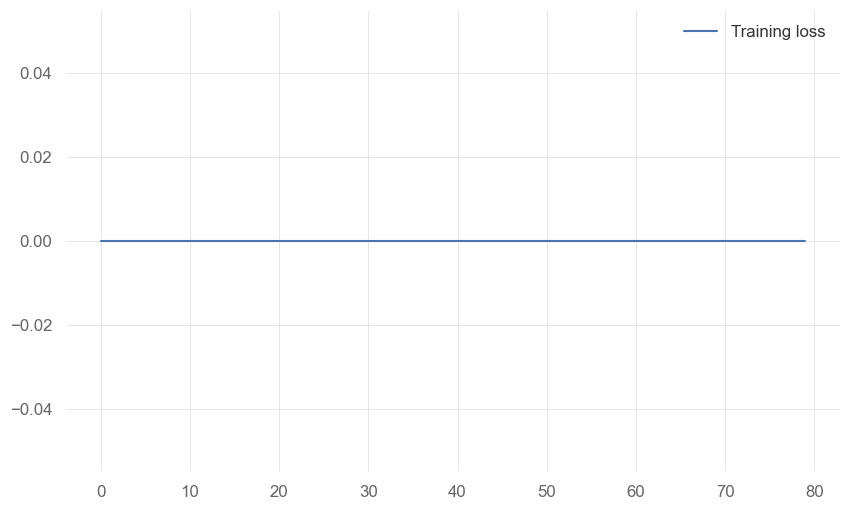

In [12]:
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

In [13]:
model.eval()  # Set the model to evaluation mode
all_predicted_labels = []

with torch.no_grad():
    for X_batch, _ in test_loader:  # Assuming test_loader is your DataLoader for the test set
        y_test_pred = model(X_batch)
        probabilities = torch.softmax(y_test_pred, dim=1)
        _, predicted_labels = torch.max(probabilities, 1)
        all_predicted_labels.extend(predicted_labels.cpu().numpy())

# Convert the list of numpy arrays into a single numpy array
predicted_labels_numpy = np.array(all_predicted_labels)


In [14]:
df_split = data.data['symbol'][-len(predicted_labels_numpy):].copy()
df_split.loc[:, "signal"] = predicted_labels_numpy
signal = df_split['signal']
entries = signal == 2
exits = signal == 0

In [15]:
pf = vbt.Portfolio.from_signals(
    close=df_split.Close, 
    long_entries=entries, 
    long_exits=exits,
    size=100,
    size_type='value',
    init_cash='auto'
)

In [16]:
pf.plot(settings=dict(bm_returns=False)).show()

In [17]:
pf.stats()

Start                         2023-06-02 13:00:00+00:00
End                           2023-12-31 06:00:00+00:00
Period                                211 days 18:00:00
Start Value                                         1.0
Min Value                                           1.0
Max Value                                           1.0
End Value                                           1.0
Total Return [%]                                    0.0
Benchmark Return [%]                         379.498581
Total Time Exposure [%]                             0.0
Max Gross Exposure [%]                              0.0
Max Drawdown [%]                                    NaN
Max Drawdown Duration                               NaT
Total Orders                                          0
Total Fees Paid                                     0.0
Total Trades                                          0
Win Rate [%]                                        NaN
Best Trade [%]                                  

In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Convert tensors to numpy arrays for use with Scikit-Learn
true_labels = y_test.cpu().numpy()
pred_labels = predicted_labels.cpu().numpy()

precision = precision_score(true_labels, pred_labels, average='macro')  # 'macro' for unweighted mean
recall = recall_score(true_labels, pred_labels, average='macro')
f1 = f1_score(true_labels, pred_labels, average='macro')
conf_matrix = confusion_matrix(true_labels, pred_labels)

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print('Confusion Matrix:\n', conf_matrix)

AttributeError: 'Series' object has no attribute 'cpu'